In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Load Dataset

In [ ]:
def load_data(train_path, test_path):
    # Load your data
    train_df = pd.read_csv(train_path, header=[0, 1])
    # Compute mean only for numeric columns
    train_df = train_df.dropna(axis=1, how='all')
    # mean_values = train_df.select_dtypes(include=[np.number]).median()

    # Fill NaNs with the computed means in the numeric columns
    train_df.fillna(0, inplace=True)
    test_df = pd.read_csv(test_path, header=[0, 1], index_col=0)
    test_df = test_df.dropna(axis=1, how='all')


    # Compute mean only for numeric columns
    mean_values = test_df.select_dtypes(include=[np.number]).median()

    # Fill NaNs with the computed means in the numeric columns
    test_df.fillna(0,inplace=True)

    train_df.replace([np.inf, -np.inf], 0, inplace=True)
    test_df.replace([np.inf, -np.inf], 0, inplace=True)

    return train_df, test_df


def to_array(train_df, test_df, group=False):
    if not group:
        train_df.columns = train_df.columns.droplevel(level=0)
        test_df.columns = test_df.columns.droplevel(level=0)

    # Prepare the datasets
    X_train = train_df.drop(['label', 'filename'], axis=1).values
    y_train = train_df['label'].values
    X_val = test_df.drop(['label', 'filename'], axis=1).values
    y_val = test_df['label'].values

    return X_train, y_train, X_val, y_val

In [ ]:
train_path = '/content/gdrive/MyDrive/speech_analysis/train_with_groups.csv'
test_path = '/content/gdrive/MyDrive/speech_analysis/test_with_groups1.csv'

train_df, test_df = load_data(train_path, test_path)
# train_df = train_df.fillna(0)
# test_df = test_df.fillna(0)
X_train_all_features, y_train, X_test_all_features, y_test = to_array(train_df.copy(), test_df.copy(), group=False)
group_names = set(train_df.columns.droplevel(level=1))
group_names.remove("Info")
feature_names = train_df.columns.droplevel(level=0).tolist()[:-2]


# Normalize features
scaler = MinMaxScaler()
X_train_all_features = scaler.fit_transform(X_train_all_features)
X_test_all_features = scaler.transform(X_test_all_features)

In [ ]:
# 129 150 166
pca = PCA(n_components=150)
X_train_pca = pca.fit_transform(X_train_all_features)
X_test_pca = pca.transform(X_test_all_features)

# Model

In [ ]:
# Define the neural network
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, 2)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

        torch.nn.init.kaiming_uniform_(self.hidden.weight, a=math.sqrt(5))
        torch.nn.init.kaiming_uniform_(self.output.weight, a=math.sqrt(5))


    def forward(self, x):
        x = self.hidden(x)
        x = self.tanh(x)
        x = self.output(x)

        return x

In [ ]:
def cv_train(X_train, y_train, hid_size=100, n_epoch=10):

    X_train_all = torch.tensor(X_train, dtype=torch.float64)
    y_train_all = torch.tensor(y_train, dtype=torch.float64)

    cv_outer = StratifiedKFold(n_splits=4, shuffle=True, random_state=2021)
    all_f1s = []
    for i, (train_ix, test_ix) in enumerate(cv_outer.split(X_train_all, y_train_all)):
        # split data
        X_train, X_val = X_train_all[train_ix, :], X_train_all[test_ix, :]
        y_train, y_val = y_train_all[train_ix], y_train_all[test_ix]

        # Create data loaders
        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_dataset = TensorDataset(X_val, y_val)
        val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

        input_size = X_train.shape[1]
        hidden_size = hid_size  # You can change this

        model = MLP(input_size, hidden_size)
        model = model.double()
        model.to("cuda")

        # Loss and optimizer
        criterion = nn.BCEWithLogitsLoss()
        # optimizer = optim.Adam(model.parameters(), lr=0.001)
        optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
        # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96)

        # Training loop
        num_epochs = n_epoch  # You can change this
        for epoch in range(num_epochs):
            model.train()
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                inputs = inputs.to("cuda")
                labels = labels.to("cuda")
                # Forward pass
                outputs = model(inputs)

                loss = criterion(outputs, labels.reshape(-1, 1))
                # Backward and optimize
                loss.backward()
                optimizer.step()
            scheduler.step()


            # Validation
            model.eval()
            all_labels = []
            all_predictions = []
            probabilities = []
            with torch.no_grad():
                for inputs, labels in val_loader:
                    outputs = model(inputs.to("cuda")).cpu()

                    outputs = model.sigmoid(outputs).round()
                    all_labels.extend(labels.tolist())
                    all_predictions.extend(outputs.reshape(-1, ).tolist())
                    probabilities.extend(outputs.reshape(-1,).tolist())


            f1 = f1_score(all_labels, all_predictions)
            # roc_auc = roc_auc_score(all_labels, probabilities)
            all_f1s.append(f1)

    return np.mean(all_f1s)

In [ ]:
def train(X_train, y_train, X_test, y_test, hid_size=100, n_epoch=10):

    X_train = torch.tensor(X_train, dtype=torch.float64)
    y_train = torch.tensor(y_train, dtype=torch.float64)
    X_test = torch.tensor(X_test, dtype=torch.float64)
    y_test = torch.tensor(y_test, dtype=torch.float64)

    # Create data loaders
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_dataset = TensorDataset(X_test, y_test)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    input_size = X_train.shape[1]
    hidden_size = hid_size  # You can change this

    model = MLP(input_size, hidden_size)
    model = model.double()
    model.to("cuda")

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(model.parameters(), lr=0.001)
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96)

    # Training loop
    num_epochs = n_epoch  # You can change this
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            inputs = inputs.to("cuda")
            labels = labels.to("cuda")
            # Forward pass
            outputs = model(inputs)
            # print(labels)
            loss = criterion(outputs, labels.long())

            # loss = criterion(outputs, labels.reshape(-1, 1))
            # Backward and optimize
            loss.backward()
            optimizer.step()
        scheduler.step()

        # Validation
        model.eval()
        all_labels = []
        all_predictions = []
        probabilities = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                # outputs = model(inputs.to("cuda")).cpu()

                # probs = model.sigmoid(outputs)
                # # print(probs.reshape(-1, ))
                # outputs = probs.round()

                outputs = model(inputs.to("cuda")).cpu()
                # print(outputs)
                _, predicted = torch.max(outputs, 1)  # Get the index of the max logit

                probs = model.softmax(outputs)[:, 1]
                # print(probs.shape)

                all_labels.extend(labels.tolist())
                all_predictions.extend(predicted.reshape(-1, ).tolist())
                probabilities.extend(probs.reshape(-1,).tolist())


            # print(all_predictions)
            f1 = f1_score(all_labels, all_predictions)
            roc_auc = roc_auc_score(all_labels, probabilities)
            res = (f1, roc_auc)
            # print(res)


    return res, probabilities

**Hyperparameter search**

In [ ]:
max_f1 = -10
all_f1s = []

for rs in [0, 3, 31, 52, 55]:
    max_f1 = -10
    for i in range(300, 600, 50):
        for j in range(5, 10, 2):
            torch.manual_seed(rs)

            f1 = cv_train(X_train_pca, y_train, hid_size=i, n_epoch=j)
            if f1 > max_f1:
                max_f1 = f1
                best = (i, j)

    torch.manual_seed(rs)
    print(best)
    res, _ = train(X_train_pca, y_train, X_test_pca, y_test, hid_size=best[0], n_epoch=best[1])
    print(res)
    all_f1s.append(res)


print(np.mean(all_f1s))

In [ ]:
all_f1s = []
all_probabilities = []

for rs in [0, 3, 20, 52, 55]:
    torch.manual_seed(rs)
    res, probs = train(X_train_pca, y_train, X_test_pca, y_test, hid_size=350, n_epoch=7)
    print(res)
    all_f1s.append(res)
    all_probabilities.append(probs)
# print(i,j)
print("mean: ", np.mean(all_f1s, axis=0))

(0.8059701492537314, 0.7992063492063493)
(0.8000000000000002, 0.8031746031746032)
(0.8115942028985507, 0.7912698412698413)
(0.7941176470588236, 0.7873015873015873)
(0.8115942028985507, 0.8015873015873016)
mean:  [0.80465524 0.79650794]


In [ ]:
# (0.8059701492537314, 0.7992063492063493)
# (0.8000000000000002, 0.8031746031746032)
# (0.8115942028985507, 0.7912698412698413)
# (0.7941176470588236, 0.7873015873015873)
# (0.8115942028985507, 0.8015873015873016)
# # mean:  [0.80465524 0.79650794

# Result curves

In [ ]:
!pip install -q scikit-plot
!pip install scipy==1.11.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 20.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.
  Using cached scipy-1.11.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached scipy-1.11.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (36.4 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, binarize
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, auc, roc_curve, confusion_matrix
from scikitplot.helpers import cumulative_gain_curve
from matplotlib.patches import Rectangle
import seaborn as sns

In [ ]:
percentages_cum_list = []
gains_list = []
# configure the cross-validation procedure
auc_values = []
sensitivities_list = []
precisions_list = []
fprs_list = []
df_density_discon_list = []

In [ ]:
step_array = np.arange (0, 1.01, 0.02)
percentage = 100 - (100*step_array)


percentages_cum = []
gains = []
percentages_cum_shape = []

auc_list = []
sensitivities = []
precisions = []
fprs = []

df_density_discon = pd.DataFrame(columns=['testy', 'Probability threshold'])



for yhat_prob1 in all_probabilities:

    df_density = pd.DataFrame()
    df_density['testy'] = y_test
    df_density['Probability threshold'] = yhat_prob1
    df_density_discon = pd.concat([df_density_discon, df_density]).reset_index(drop=True)


    thesh_steps = np.quantile(yhat_prob1, step_array)
    thresholds = np.round(thesh_steps, 4)


    sensitivity = []
    precision = []
    fpr_list = []
    for thresh in  thresholds:
        y_pred_class = binarize([yhat_prob1], threshold = thresh)[0]
        confusion = confusion_matrix(y_test, y_pred_class)
        TP = confusion[1, 1]
        TN = confusion[0, 0]
        FP = confusion[0, 1]
        FN = confusion[1, 0]
        sens = TP/(TP+FN)
        prec = TP/(TP+FP)
        fpr  = FP/(TN+FP)
        sensitivity.append(sens)
        precision.append(prec)
        fpr_list.append(fpr)


    fprs.append(fpr_list)
    sensitivities.append(sensitivity)
    precisions.append(precision)
    # auc from sklearn
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, yhat_prob1)
    auc_ = auc(false_positive_rate, true_positive_rate)
    auc_list.append(auc_)

    # Cumulative Gain
    classes = np.unique(y_test)
    percentage_cum, gain = cumulative_gain_curve(y_test, yhat_prob1, classes[1])
    percentages_cum_shape.append(percentage_cum.shape[0])
    percentages_cum.append(percentage_cum)
    gains.append(gain)



percentages_cum_list.append([p_cum[:min(percentages_cum_shape)] for p_cum in percentages_cum])
gains_list.append([gain_[:min(percentages_cum_shape)] for gain_ in gains])
sensitivities_list.append(sensitivities)
precisions_list.append(precisions)
fprs_list.append(fprs)
auc_values.append(np.mean(auc_list))
df_density_discon_list.append(df_density_discon)

<ipython-input-38-af3e4720aaba>:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_density_discon = pd.concat([df_density_discon, df_density]).reset_index(drop=True)
<ipython-input-38-af3e4720aaba>:41: RuntimeWarning: invalid value encountered in scalar divide
  prec = TP/(TP+FP)
<ipython-input-38-af3e4720aaba>:41: RuntimeWarning: invalid value encountered in scalar divide
  prec = TP/(TP+FP)


In [ ]:
def plot_figures(sensitivities, precisions, fprs, auc, gains, percentages_cum, df_density_discon, colors, labels, bbox_to_anchor_roc, path_to_save):
    font = {}
    font_title = {}
    step_array = np.arange (0, 1.01, 0.02)
    percentage = 100 - (100*step_array)

    fig, axs = plt.subplots(2, 3, figsize=(22, 12))

    sensitivities_1 = np.array(sensitivities[0])
    mean_sens_1 = np.mean(sensitivities_1, axis=0)
    # mean_sens_1 = sensitivities_1[1]


    precisions_1 = np.array(precisions[0])
    mean_prec_1 = np.mean(precisions_1, axis=0)
    # mean_prec_1 = precisions_1[1]

    fprs_1 = np.array(fprs[0])
    mean_fprs_1 = np.mean(fprs_1, axis=0)
    # mean_fprs_1 = fprs_1[1]

    gains_1 = np.array(gains[0])
    mean_g_1 = np.mean(gains_1, axis=0)
    # mean_g_1 = gains_1[2]

    percentages_cum_1 = np.array(percentages_cum[0])
    mean_per_cum_1 = np.mean(percentages_cum_1, axis=0)
    # mean_per_cum_1 = percentages_cum_1[1]

    im1 ,=axs[0, 0].plot(mean_fprs_1 * 100, mean_sens_1 * 100, color=colors[0], lw=3)
    axs[0, 0].plot([0, 100], [0, 100], linestyle="--", color="black", lw=1)
    axs[0, 0].set_title("A) ROC", fontdict=font_title, loc="left")
    axs[0, 0].set_xlabel("1-Specificity (%)", fontdict=font)
    axs[0, 0].set_ylabel("Sensitivity (%)", fontdict=font)
    axs[0, 0].yaxis.grid(True)
    # Hide the right and top spines
    axs[0, 0].spines['right'].set_visible(False)
    axs[0, 0].spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    axs[0, 0].yaxis.set_ticks_position('left')
    axs[0, 0].xaxis.set_ticks_position('bottom')
    # create blank rectangle
    extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    #Create organized list containing all handles for table. Extra represent empty space
    legend_handle = [extra, im1, extra, extra, extra, extra, extra, extra, extra, extra]
    #Define the labels
    label_row_1 = []
    #organize labels for table construction
    legend_labels = np.concatenate([label_row_1])
    #Create legend
    axs[0, 0].legend(legend_handle, legend_labels, ncol = 3, shadow = True, handletextpad = -2, bbox_to_anchor=bbox_to_anchor_roc, prop={'size': 8})

    axs[0, 1].plot(mean_sens_1 * 100, mean_prec_1 * 100, color=colors[0], lw=3, label=labels[0])
    axs[0, 1].set_title("B) Precision vs Recall", fontdict=font_title, loc="left")
    axs[0, 1].set_xlabel("(Recall) Sensitivity (%)", fontdict=font)
    axs[0, 1].set_ylabel("(Precision) Positive predictive value (%)", fontdict=font)
    axs[0, 1].yaxis.grid(True)
    # axs[0, 1].legend(bbox_to_anchor=(0.7,0.37), shadow = True)
    # Hide the right and top spines
    axs[0, 1].spines['right'].set_visible(False)
    axs[0, 1].spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    axs[0, 1].yaxis.set_ticks_position('left')
    axs[0, 1].xaxis.set_ticks_position('bottom')

    axs[1, 1].plot(mean_per_cum_1 * 100, mean_g_1 * 100, color=colors[0], lw=3, label=labels[0])
    axs[1, 1].plot([0, 100], [0, 100], linestyle="--", color="black", lw=1)
    axs[1, 1].set_title("E) Cumulative Gains Curve", fontdict=font_title, loc="left")
    axs[1, 1].set_xlabel("Percentage of sample (%)", fontdict=font)
    axs[1, 1].set_ylabel("Gain (%)", fontdict=font)
    axs[1, 1].yaxis.grid(True)
    axs[1, 1].set(ylim=[-5, 105])
    # axs[1, 1].legend(bbox_to_anchor=(1.0,0.37), shadow = True)
    # Hide the right and top spines
    axs[1, 1].spines['right'].set_visible(False)
    axs[1, 1].spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    axs[1, 1].yaxis.set_ticks_position('left')
    axs[1, 1].xaxis.set_ticks_position('bottom')

    axs[0, 2].plot(percentage, mean_prec_1 * 100, color=colors[0], lw=3, label=labels[0])
    axs[0, 2].set_title("C) Precision (Positive Predictive Value)", fontdict=font_title, loc="left")
    axs[0, 2].set_xlabel("Percentile of predicted probability", fontdict=font)
    axs[0, 2].set_ylabel("Positive predictive value (%)", fontdict=font)
    axs[0, 2].yaxis.grid(True)
    axs[0, 2].set(ylim=[-5, 105])
    axs[0, 2].legend(bbox_to_anchor=(1,0.37), shadow = True, prop={'size': 9.5})
    # Hide the right and top spines
    axs[0, 2].spines['right'].set_visible(False)
    axs[0, 2].spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    axs[0, 2].yaxis.set_ticks_position('left')
    axs[0, 2].xaxis.set_ticks_position('bottom')


    axs[1, 0].plot(percentage, mean_sens_1 * 100, color=colors[0], lw=3, label=labels[0])
    axs[1, 0].set_title("D) Recall (Sensitivity)", fontdict=font_title, loc="left")
    axs[1, 0].set_xlabel("Percentile of predicted probability", fontdict=font)
    axs[1, 0].set_ylabel("Sensitivity (%)", fontdict=font)
    axs[1, 0].yaxis.grid(True)
    # axs[1, 0].legend(bbox_to_anchor=(0.12, 0.23), shadow = True)
    # Hide the right and top spines
    axs[1, 0].spines['right'].set_visible(False)
    axs[1, 0].spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    axs[1, 0].yaxis.set_ticks_position('left')
    axs[1, 0].xaxis.set_ticks_position('bottom')

    # axs[1, 2] = sns.distplot(df_density_discon[df_density_discon["testy"] == 0]['Probability threshold'],
    #                          hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3, 'bw':0.4}, label = 'class 0')
    # axs[1, 2] = sns.distplot(df_density_discon[df_density_discon["testy"] == 1]['Probability threshold'],
    #                          hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3, 'bw':0.4}, label = 'class 1')
    # axs[1, 2].set_xlim(0, 1)
    # axs[1, 2].yaxis.grid(True)
    # # Hide the right and top spines
    # axs[1, 2].spines['right'].set_visible(False)
    # axs[1, 2].spines['top'].set_visible(False)
    # # Only show ticks on the left and bottom spines
    # axs[1, 2].yaxis.set_ticks_position('left')
    # axs[1, 2].xaxis.set_ticks_position('bottom')
    # axs[1, 2].legend(bbox_to_anchor=(0.6, 0.9), title="Entity type")
    # axs[1, 2].set_title("F) Prediction Density", fontdict=font_title, loc="left")
    # axs[1, 2].set_xlabel("Probability threshold", fontdict=font)
    # axs[1, 2].set_ylabel("Density", fontdict=font)
    fig.delaxes(axs[1, 2])

    fig.savefig(path_to_save, bbox_inches='tight', dpi=600)
    plt.show()



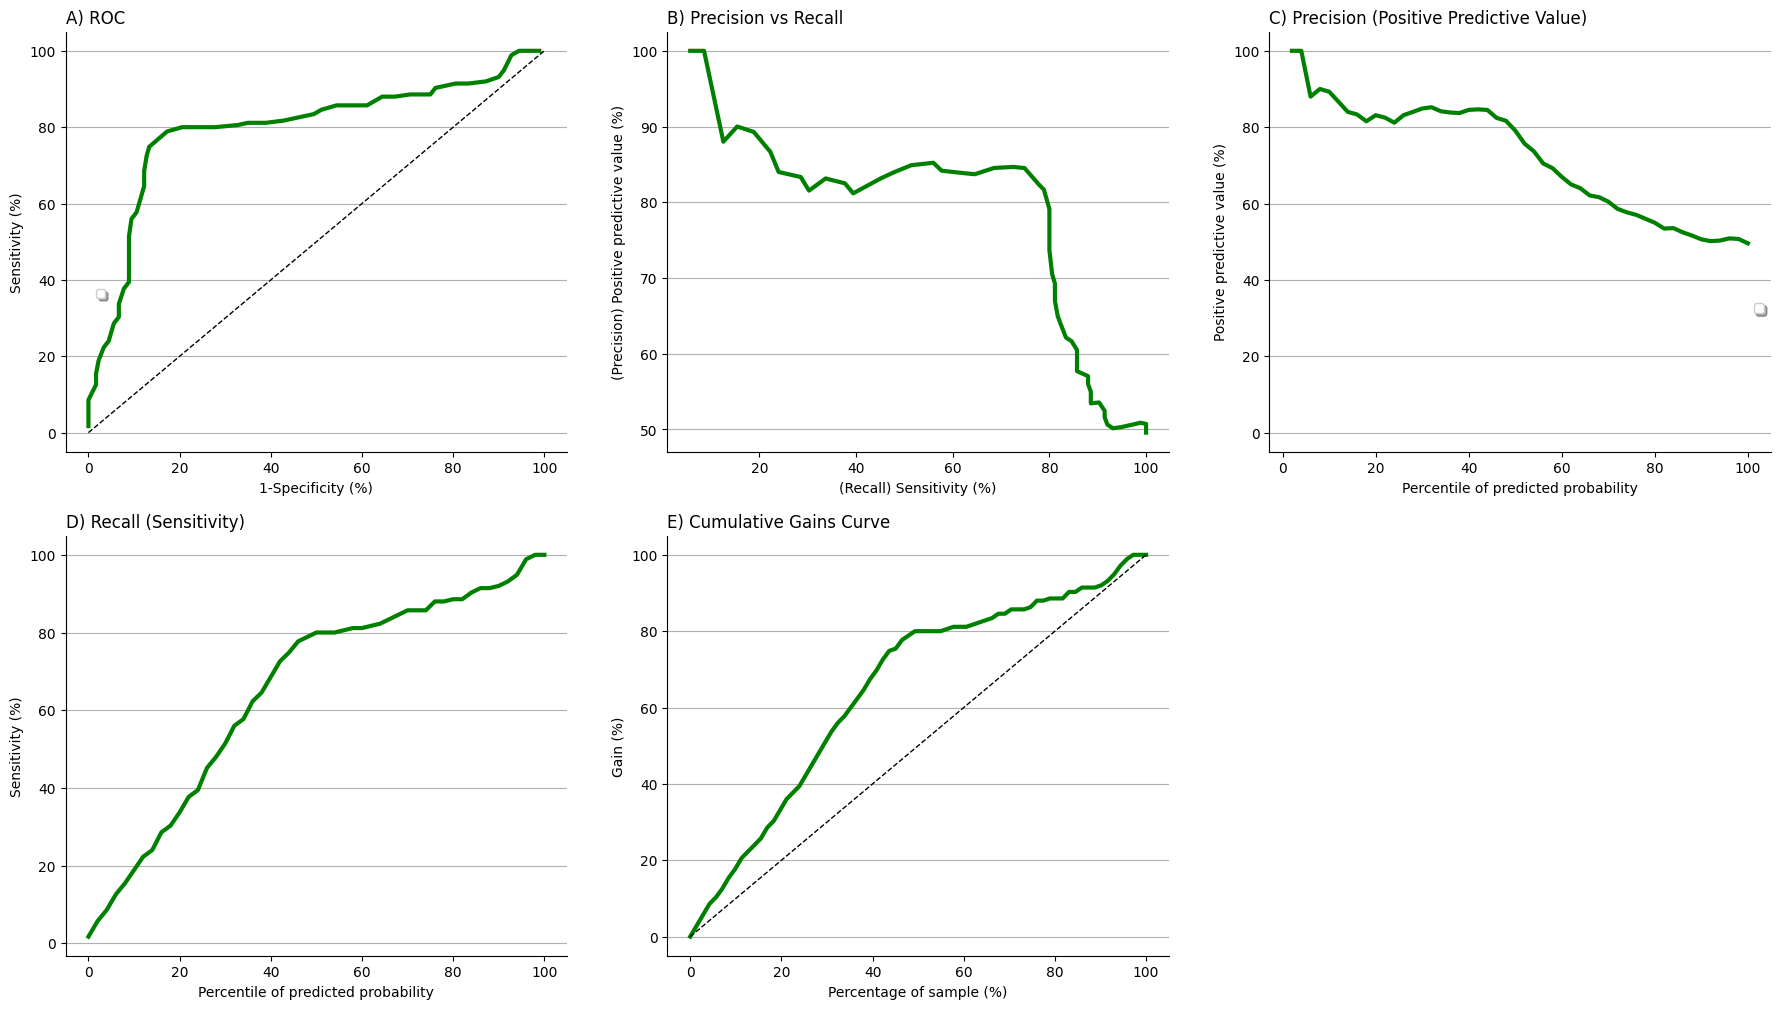

In [ ]:
path_to_save = "ML_res.svg"
color_list = ["green", "darkblue", "darkred"]
pipline_labels = [""]
bbox_to_anchor_roc = (0.09, 0.4)
plot_figures(sensitivities_list, precisions_list, fprs_list, auc_list, gains_list, percentages_cum_list, df_density_discon_list[0],
                                                                                color_list, pipline_labels, bbox_to_anchor_roc, path_to_save)


In [ ]:
auc_list

[0.7992063492063493,
 0.8031746031746032,
 0.7912698412698413,
 0.7873015873015873,
 0.8015873015873016]